<center><h1><b>Potato Disease Classification Project</b></h1></center>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/729b55d7-2a99-4861-910d-3b4e2bbce13a___JR_B.Spot 9036.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b143a281-5395-4a2a-830

In [2]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

### Putting the datasets in training directory

In [3]:
# Define the source directory and the specific subdirectories to copy
source_dir = Path("/kaggle/input/plant-village/PlantVillage")
target_subdirs = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy"
]

# Define the destination directory where you want to copy the datasets
destination_dir = Path("/kaggle/working/training")

# Clear the existing 'training' directory if it exists, then recreate it
if destination_dir.exists() and destination_dir.is_dir():
    shutil.rmtree(destination_dir)
destination_dir.mkdir(parents=True, exist_ok=True)

# Loop through the specified subdirectories and copy them to the 'training' directory
for subdir in target_subdirs:
    src_path = source_dir / subdir
    dst_path = destination_dir / subdir
    
    # Check if the source directory exists before copying
    if src_path.exists():
        try:
            shutil.copytree(src_path, dst_path)
            print(f"Copied {src_path} to {dst_path}")
        except Exception as e:
            print(f"Failed to copy {src_path}: {e}")
    else:
        print(f"Directory {src_path} not found!")

print("Selected datasets have been copied successfully!")


Copied /kaggle/input/plant-village/PlantVillage/Potato___Early_blight to /kaggle/working/training/Potato___Early_blight
Copied /kaggle/input/plant-village/PlantVillage/Potato___Late_blight to /kaggle/working/training/Potato___Late_blight
Copied /kaggle/input/plant-village/PlantVillage/Potato___healthy to /kaggle/working/training/Potato___healthy
Selected datasets have been copied successfully!


### Data Processing

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3  # RGB
EPOCHS = 50

In [5]:
# Creating a tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'training',  # The directory that contain the datasets
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
# TO know the class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
# Number of total batches created with the batch size sed
len(dataset)

68

In [8]:
# To see the number of images in each batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 0 2 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1]


In [9]:
# To print first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].shape)

[[[127. 115. 119.]
  [132. 120. 124.]
  [134. 122. 126.]
  ...
  [131. 119. 119.]
  [127. 115. 115.]
  [135. 123. 123.]]

 [[135. 123. 127.]
  [133. 121. 125.]
  [127. 115. 119.]
  ...
  [150. 138. 138.]
  [149. 137. 137.]
  [153. 141. 141.]]

 [[139. 127. 131.]
  [133. 121. 125.]
  [123. 111. 115.]
  ...
  [148. 136. 136.]
  [151. 139. 139.]
  [152. 140. 140.]]

 ...

 [[161. 151. 159.]
  [158. 148. 156.]
  [161. 151. 159.]
  ...
  [179. 168. 172.]
  [177. 166. 170.]
  [177. 166. 170.]]

 [[160. 150. 158.]
  [161. 151. 159.]
  [164. 154. 162.]
  ...
  [176. 165. 169.]
  [176. 165. 169.]
  [177. 166. 170.]]

 [[153. 143. 151.]
  [158. 148. 156.]
  [163. 153. 161.]
  ...
  [175. 164. 168.]
  [179. 168. 172.]
  [183. 172. 176.]]]
(256, 256, 3)


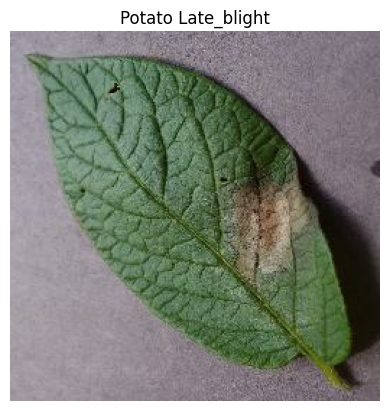

In [10]:
# Visualizing the first image
for image_batch, label_batch in dataset.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]].replace('___', ' '))
    plt.axis('off')

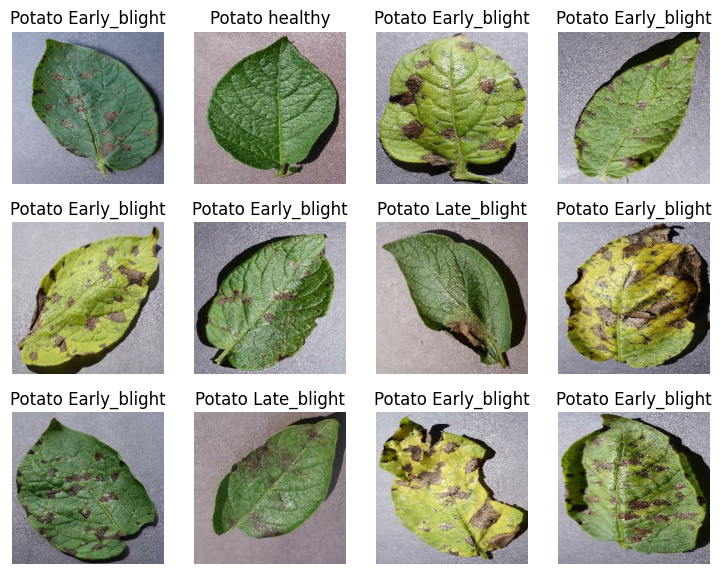

In [11]:
# Visualizing the first 12 images in a batch
plt.figure(figsize=(9,7))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]].replace('___', ' '))
        plt.axis('off')

### Splitting The Dataset to Train, Validation, and Test set

The validation set will be used to test each epoch during training. The test set will be used to measure overall accuracy.

In [12]:
train_pct = 0.8
train_size = round(len(dataset) * train_pct)
train_size

54

In [13]:
train_dataset = dataset.take(train_size)
len(train_dataset)

54

In [14]:
test_ds = dataset.skip(train_size)
len(test_ds)

14

In [15]:
validation_pct = 0.1
validation_size = round(len(dataset) * validation_pct)
validation_dataset = test_ds.take(validation_size)
len(validation_dataset)

7

In [16]:
test_size = test_ds.skip(validation_size)
len(test_size)

7

In [17]:
train_data = train_dataset
validation_data = validation_dataset
test_data = test_size

In [18]:
len(train_data), len(validation_data), len(test_data)

(54, 7, 7)

In [19]:
# Definning a function to separate train, validation and test dataset

def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, test_split=0.1, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=0)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [21]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [22]:
# activating cache, shuffle, prefetch operations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
# To resize and rescale the images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [24]:
# Aumentation of the datasets
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

### Building CNN Model

In [25]:
# Define input shape and number of classes
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# Build the model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9918 - loss: 0.0303 - val_accuracy: 0.9844 - val_loss: 0.0389
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9915 - loss: 0.0205 - val_accuracy: 0.9948 - val_loss: 0.0120
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9936 - loss: 0.0245 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9967 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9929 - loss: 0.0254 - val_accuracy: 0.9948 - val_loss: 0.0287
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9840 - loss: 0.0375 - val_accuracy: 0.9896 - val_loss: 0.0442
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9947 - loss: 0.0135 - val_accuracy: 0.9896 - val_loss: 0.0142
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.9948 - v

In [39]:
# model evaluation
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0033 


#### Checking the params and usefulness of history

In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [41]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
# List of accuracies record during training 
history.history['accuracy']

[0.9935445785522461,
 0.9911971688270569,
 0.9964788556098938,
 0.9976525902748108,
 0.9841549396514893,
 0.9906103014945984,
 0.9964788556098938,
 0.9994131326675415,
 0.9941314458847046,
 0.9964788556098938,
 0.9929577708244324,
 0.9953051805496216,
 0.9976525902748108,
 0.9947183132171631,
 0.9970657229423523,
 0.9976525902748108,
 1.0,
 0.998826265335083,
 0.9935445785522461,
 0.9888497591018677,
 0.9994131326675415,
 0.9970657229423523,
 0.9970657229423523,
 0.9865023493766785,
 0.9841549396514893,
 0.9953051805496216,
 0.9994131326675415,
 1.0,
 0.998826265335083,
 0.9929577708244324,
 0.9970657229423523,
 0.9994131326675415,
 1.0,
 1.0,
 0.998826265335083,
 1.0,
 0.998826265335083,
 0.9964788556098938,
 0.9888497591018677,
 0.9906103014945984,
 0.9935445785522461,
 0.9970657229423523,
 0.9976525902748108,
 0.9964788556098938,
 0.9970657229423523,
 0.9970657229423523,
 0.9941314458847046,
 0.9964788556098938,
 0.9982394576072693,
 0.9941314458847046]

#### Plotting the history metrics

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

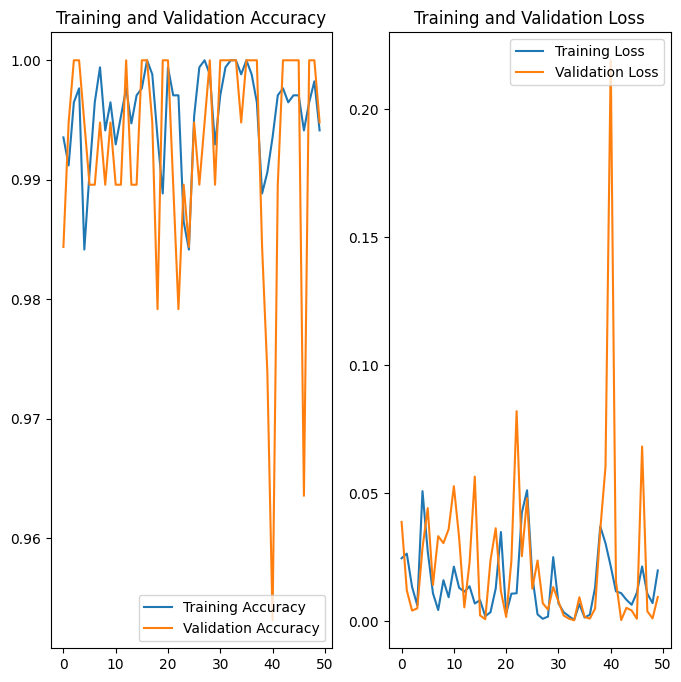

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Chart
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss');

### Predictions

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted Label: Potato___Late_blight


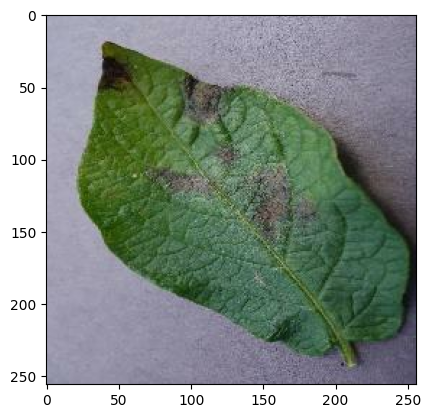

In [45]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(f'Predicted Label: {class_names[np.argmax(batch_prediction[0])]}')

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


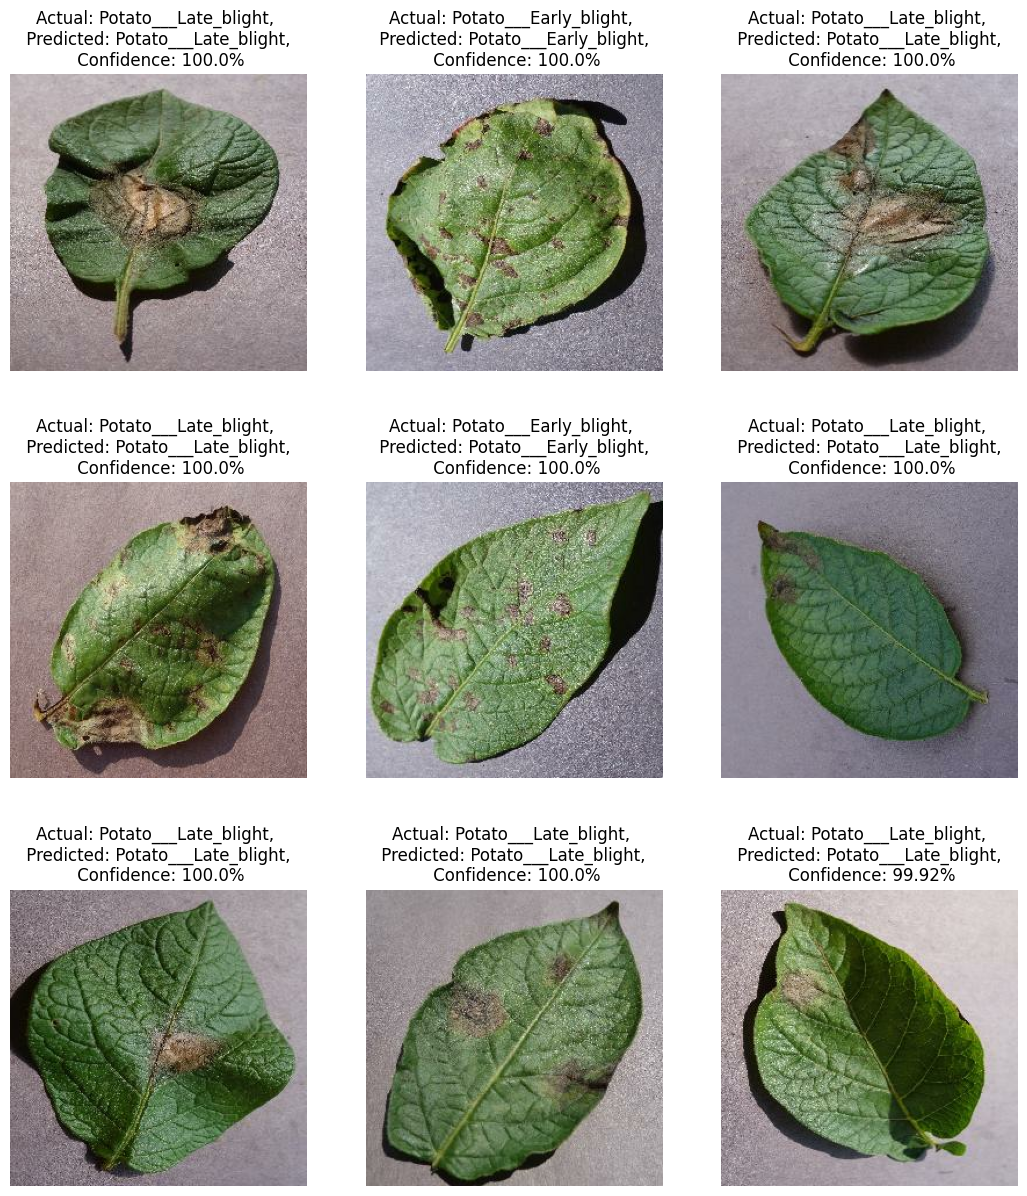

In [47]:
plt.figure(figsize=(13, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%')
        plt.axis('off')

In [48]:
model_version= 'potato_model1.keras'
model.save(model_version)

In [ ]:
# To save different versions of model created separately
model_version = max([int(i) for i in os.listdir('../models') + [0]]) + 1
model.save(f'../models/{model_version}')